# MDP Policy Evaluation using Dynamic Programming - Gridworld

* **Description:** Perform iterative policy evaluation for the gridworld example
* **Reference:** Reinforcement Learning, An Introduction, Second Edition by Sutton, Barto
* **Section:** Section 4.1, Example 4.1, Pg. 76 to 77

# Import required libraries

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

from tqdm import tqdm

# Define classes and functions

## Class: Agent

In [2]:
class Agent(object):
    '''
    Defines the agent class for the gridworld problem
    Arguments:
        policy_init: Initial policy to use for the agent class
        actions: List of actions that the agent can take
    '''
    
    def __init__(self, policy_init, actions):
        self.policy = policy_init
        self.actions = actions
        
    def step(self, state):
        # Execute one step of agent based on current state
        if isinstance(self.policy, str):
            if(self.policy == 'random'): # Choose an action randomly for 'random' policy
                return np.random.choice(self.actions)        
        

## Class: Environment

In [3]:
class Environment(object):
    '''
    Defines the environment class for a n x n gridworld problem
    Arguments:
        n: Defines the size of the gridworld. n x n gridworld is generated
        reward: Reward value for each transition
    '''
    
    def __init__(self, n, reward):
        self.n = n
        self.state_list = list(range(n ** 2))
        self.reward = reward
        
    def set_state(self, state): # Set the environment to a particular state
        self.state = state
        
    def respond(self, action): # Respond to a particular action
        if (self.state == 0 or self.state == (self.n ** 2 - 1)): 
            # Terminal states. Stay in that state for any action and return reward = 0
            return self.state, 0
        else:
            if (action == 'up'): # Execute up action
                if (self.state < self.n):
                    self.state = self.state
                else:
                    self.state = self.state - 4
            if (action == 'down'): # Execute down action
                if (self.state >= (self.n * (self.n - 1))):
                    self.state = self.state
                else:
                    self.state = self.state + 4
            if (action == 'right'): # Execute right action
                if ((self.state + 1) % self.n == 0):
                    self.state = self.state
                else:
                    self.state = self.state + 1
            if (action == 'left'): # Execute left action
                if (self.state % self.n == 0):
                    self.state = self.state
                else:
                    self.state = self.state - 1
            return self.state, self.reward    

## Function: iter_pol_eval

In [37]:
def iter_pol_eval(svf_init, actions_list, gw_envir, theta, plot_iter_ind, num_cols, plot = False):
    '''
    Run the iterative policy evaluation algorithm - Non in-place method
    Arguments:
        svf_init: Initial state-value function
        actions_list: List of actions that agent can take.
        gw_envir: Environment instance
        theta: Accuracy threshold at which to stop iteration (Pg. 97 of RL_Sutton) 
        plot_iter_ind: Iteration indices at which value functions will be plotted
        num_cols: Number of columns to use for plotting
        plot: boolean. If True, plot value functions
    '''

    num_plots = len(plot_iter_ind) + 2 # Plot initial and final value functions also
    num_rows = math.ceil(num_plots / num_cols) # Number of rows to use for plotting
    fig = plt.figure(figsize = ((num_cols * 3), (num_rows * 3.2)))
    fig.suptitle('State Value Functions at different iterations', fontsize = 30)
    sns.set(font_scale = 1.15)
    
    ind = 1 # Initialize iteration index 
    gw_size = int(np.sqrt(len(svf_init)))
    plot_ind = 1
    while(1): # Run iterative policy evaluation till convergence
        if (ind == 1):
            svf_curr = svf_init # Initialize current state value function in first iteration
        else:
            svf_curr = svf_next
        svf_next = np.zeros(len(svf_init)) # v_(k+1): Placeholder for next state value function.        
        # Loop through all states (leave out terminal states)
        for s in range(1, (len(svf_init) - 1)): 
            for act in actions_list: # Execute all actions for each state
                gw_envir.set_state(s)
                s_pr, r = gw_envir.respond(act) # Get next state and reward from environment
                # Note: Only one possible next state, reward for each s,a pair
                # So, p(s',r|s,a) = 1
                svf_next[s] += r + svf_curr[s_pr] # Update next state value function
            # For equiprobable random policy pi(a|s) = 1/(num_actions)
            svf_next[s] = svf_next[s] / len(actions_list)
        
        # Plot value function
        if (plot):
            if (ind == 1):
                ax = plt.subplot(num_rows, num_cols, (plot_ind))
                ax.set_title(f"Initial_Value_Function", fontsize = 15)
                svf_table_df = pd.DataFrame(svf_curr.reshape(gw_size, gw_size))
                sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
                            cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
                            linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax)
                plot_ind += 1
            if (ind in plot_iter_ind):
                ax = plt.subplot(num_rows, num_cols, (plot_ind))
                ax.set_title(f"Iteration: {ind}", fontsize = 15)
                svf_table_df = pd.DataFrame(svf_next.reshape(gw_size, gw_size))
                sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
                            cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
                            linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax) 
                plot_ind += 1
            
        # Compute delta
        svf_delta = svf_next - svf_curr
        delta = np.dot(svf_delta, svf_delta.T)
        if (delta < theta):
            break
        ind += 1
    
    if (plot):
        ax = plt.subplot(num_rows, num_cols, (plot_ind))
        ax.set_title(f"Final_Value_Function", fontsize = 15)
        svf_table_df = pd.DataFrame(svf_next.reshape(gw_size, gw_size))
        sns.heatmap(svf_table_df, annot = True, cbar = False, square = True,\
                    cmap = 'Greys', vmin = 0, fmt = "0.1f", linewidths = 1,\
                    linecolor = 'black', xticklabels = False, yticklabels = False, ax = ax) 
        
    return ind, svf_next

# Initialize RL system

In [5]:
policy_init = 'random' # Set initial policy to equiprobable random policy
actions_list = ['up', 'down', 'right', 'left']
gw_size = 4 # 4 x 4 gridworld

gw_agent = Agent(policy_init, actions_list) # Instantiate agent
gw_envir = Environment(gw_size, -1) # Instantiate environment

# Run Iterative Policy Evaluation

Policy evaluation converged in 131 steps


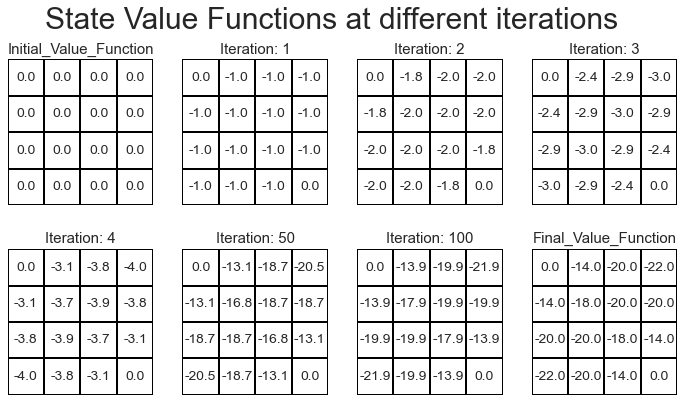

In [38]:
svf_init = np.zeros(gw_size ** 2) # v_0: Initialize value function array to all zeros.
theta = 1e-5 # Accuracy threshold at which to stop iteration
num_cols = 4
plot_iter_ind = [1, 2, 3, 4, 50, 100]

# Run iterative policy evaluation
ind, svf_final = iter_pol_eval(svf_init, actions_list, gw_envir, theta, plot_iter_ind,\
                               num_cols, True)
print(f"Policy evaluation converged in {ind} steps")    

# Run agent

In [ ]:
num_runs = 10000
reward_list = []
for run in tqdm(range(num_runs)):
    gw_envir.set_state(4)
    reward = 0
    while(1):
        s = gw_envir.state
        action = gw_agent.step(s)
        s_pr, r = gw_envir.respond(action)
        reward += r
        # print(s, action, s_pr, r)
        if (s_pr == 0 or s_pr == 15):
            break
    reward_list.append(reward)
# print(reward_list)    
print(np.mean(reward_list))